# Twitter US Airline Sentiment

## Importing libraries

In [1]:
# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For data visualization
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


## Reading data

In [4]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568503966687993856,negative,1.0000,Lost Luggage,0.6616,Delta,NaN,HAbbott4,NaN,0,@JetBlue My bag is missing from 1099 landed ov...,NaN,2015-02-19 12:14:42 -0800,NY,Eastern Time (US & Canada)
1,570264153559949313,positive,0.6630,NaN,0.0000,United,NaN,JoshuaIsWrong,NaN,0,"@united 441, which also had 1 working WC in co...",NaN,2015-02-24 08:49:03 -0800,Austin · LA · London · NY · SF,Eastern Time (US & Canada)
2,569939286935674880,negative,1.0000,Customer Service Issue,0.3422,US Airways,NaN,juliebartz,NaN,0,@USAirways well that is not going to help. I'v...,NaN,2015-02-23 11:18:09 -0800,Shawano WI,Central Time (US & Canada)
3,569347125575725057,negative,1.0000,Cancelled Flight,0.6735,Southwest,NaN,kaylariley03,NaN,0,@SouthwestAir been waiting for 70 minutes on h...,NaN,2015-02-21 20:05:07 -0800,NaN,Eastern Time (US & Canada)
4,570115286289899520,negative,0.6953,Cancelled Flight,0.3628,American,NaN,UncleDomDom,NaN,0,"@AmericanAir yeah, buy me a @Delta plane ticke...",NaN,2015-02-23 22:57:31 -0800,NaN,Eastern Time (US & Canada)


In [6]:
data.shape

(14640, 15)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


**As we are interested in sentiments and airline text so, we will all columns except the airline_sentiment and text column.**

In [8]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,negative,@JetBlue My bag is missing from 1099 landed ov...
1,positive,"@united 441, which also had 1 working WC in co..."
2,negative,@USAirways well that is not going to help. I'v...
3,negative,@SouthwestAir been waiting for 70 minutes on h...
4,negative,"@AmericanAir yeah, buy me a @Delta plane ticke..."


In [9]:
data.shape

(14640, 2)

## Getting to know data

In [10]:
data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

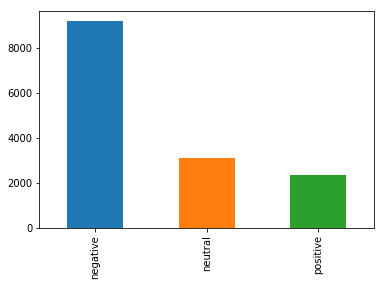

In [11]:
# Visualization is always better
data['airline_sentiment'].value_counts().sort_index().plot.bar()

**There is a danger of sample biasness and we have big difference in positive sentiments vs others.**

In [12]:
data['text'][0:5]

0    @JetBlue My bag is missing from 1099 landed ov...
1    @united 441, which also had 1 working WC in co...
2    @USAirways well that is not going to help. I'v...
3    @SouthwestAir been waiting for 70 minutes on h...
4    @AmericanAir yeah, buy me a @Delta plane ticke...
Name: text, dtype: object

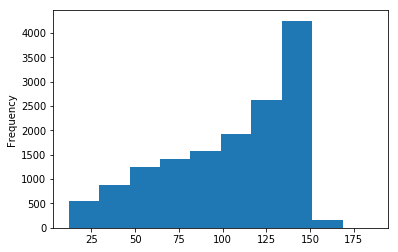

In [13]:
data['text'].str.len().plot.hist()

## Drawing wordcloud

In [14]:
from wordcloud import WordCloud, STOPWORDS

In [15]:
stopwords=set(STOPWORDS)

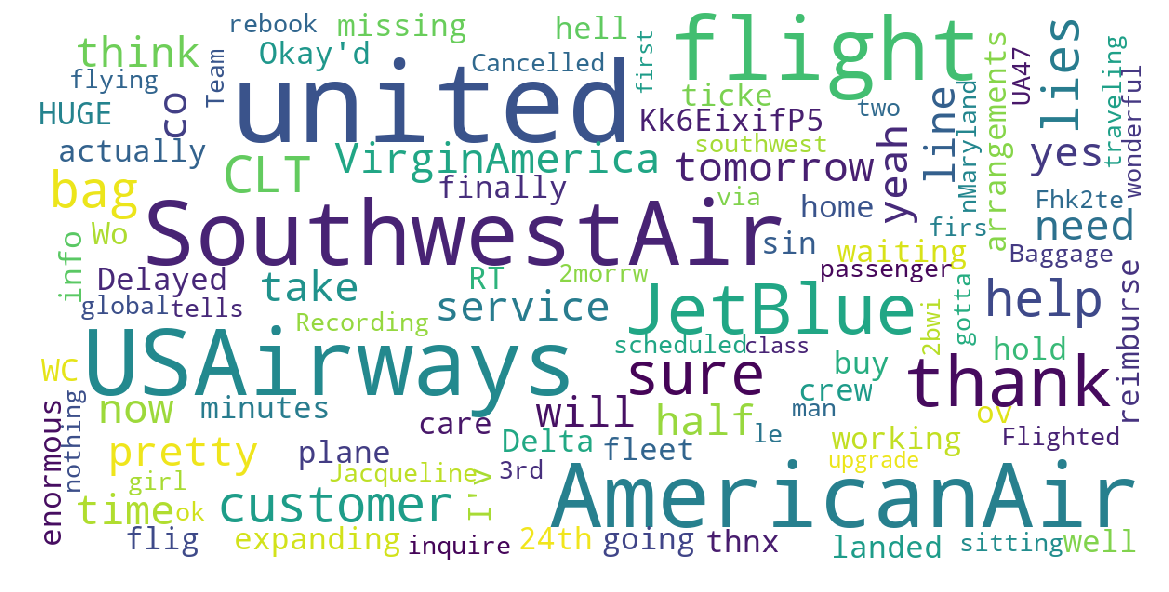

In [16]:
def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 100 ,
    max_font_size=40 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()

Mywordcloud(data["text"].dropna())

## Cleaning Data

In [17]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0    JetBlue My bag is missing from 1099 landed ove...
1    united 441 which also had 1 working WC in coac...
2    USAirways well that is not going to help Ivebe...
3    SouthwestAir been waiting for 70 minutes on ho...
4    AmericanAir yeah buy me a Delta plane ticket f...
Name: text, dtype: object

## Tokenizer

In [18]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   17,   11,
          88,   14,  309,   33, 4604,  429,  101,  312,   56,  285,   46],
       [   0,    0,    0,    0,    0,    0,    0,    0,    5, 3670,  333,
         279,   81,  218,  303, 3671,   15, 1204,  133,  488,   29, 1371,
         429, 1257,   18,  807,    3,   22,    1,  250,    2, 3671, 2459],
       [   0,    0,    0,    0,    0,    0,    0,   12,  187,   26,   14,
          24,  118,    1,   46,    9,   62,  101,  122,  176,   61,   11,
        2225, 1694,  417, 2056, 4605,   15,    2,  744,  955, 1429, 3672],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   16,   45,  107,    7, 1695,  137,    9,
          62,  120,  405,   37,   83,   11,  473,    8,  325,    2,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   13,
         659,  660,   19,    4,  3

## Embedding & LSTM Model

In [19]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


## Dealing with dummy variables

In [22]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0 0]
positive [0 0 1]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

## Splitting dataset into train and test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Training model

In [24]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
 - 67s - loss: 0.6659 - acc: 0.7246
Epoch 2/8
 - 73s - loss: 0.4512 - acc: 0.8274
Epoch 3/8
 - 74s - loss: 0.3668 - acc: 0.8590
Epoch 4/8
 - 75s - loss: 0.2996 - acc: 0.8859
Epoch 5/8
 - 74s - loss: 0.2585 - acc: 0.9036
Epoch 6/8
 - 75s - loss: 0.2160 - acc: 0.9212
Epoch 7/8
 - 73s - loss: 0.1821 - acc: 0.9340
Epoch 8/8
 - 74s - loss: 0.1550 - acc: 0.9439


## Testing model

In [25]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

JetBlue My bag is missing from 1099 landed over 6 hours ago Help [9.9967647e-01 3.0696031e-04 1.6618123e-05] [1 0 0]
united 441 which also had 1 working WC in coach Good thing this bird landed ahead of schedule I have to use the WC stat [9.9919361e-01 7.1623403e-04 9.0155096e-05] [1 0 0]
USAirways well that is not going to help Ivebeen on hold over 3 hrs amp my client wants his ff nbr in the record hes elite wAA [9.9409086e-01 5.6345719e-03 2.7461705e-04] [0 1 0]
SouthwestAir been waiting for 70 minutes on hold because yall Cancelled Flightled my return flight Answer the phone [0.10294954 0.04448728 0.8525632 ] [1 0 0]
AmericanAir yeah buy me a Delta plane ticket from San Diego to Detroit so I can fly one of their planes home tomorrow [0.71817964 0.1900168  0.09180359] [1 0 0]


[None, None, None, None, None]

In [26]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 430
Neutral predictions: 474
Negative predictions: 2024
Real positive: 468
Real neutral: 603
Real negative: 1857
